## Install Package

In [ ]:
!pip install PySastrawi

     |████████████████████████████████| 215kB 2.6MB/s 


In [ ]:
!pip install wordcloud

In [ ]:
!pip install squarify

## Import Library

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline


import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer

from collections import Counter


from tqdm import tqdm
import os 

import re

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from wordcloud import WordCloud, STOPWORDS 

import joblib

import pickle

import warnings
warnings.filterwarnings("ignore")



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Explore Data

In [ ]:
BASE_PATH = '/content/drive/My Drive/Project/Data Science/PeduliLindungi Sentimen Analisis'

print(os.listdir(BASE_PATH))
# Dataset 
print(os.listdir(os.path.join(BASE_PATH, 'dataset')))

['Sentiment Analysis using ML and DL model.ipynb', 'App Review Scraping.ipynb', 'dataset', 'model', '.ipynb_checkpoints', '__pycache__', 'preprocessing.py', 'PeduliLindungi Sentimen Analysis Pre Train Model.ipynb']
['Datacampur.xlsx', 'MisterAladin.csv', 'Pegipegi.csv', 'DataTrain.csv', 'traveloka-uji.csv', 'tiketcom-uji.csv', 'pegipegi-uji.csv', 'misteraladin-uji.csv', 'apps.csv', 'app_reviews.csv', 'app_reviews.gsheet']


In [ ]:
# Load dataset
df = pd.read_excel(os.path.join(BASE_PATH, 'dataset/Datacampur.xlsx'))
df.head()

,Name,Review,Label
0,Yuki Audhia,Kesekian kalinya beli tiket kereta api disini ...,POSITIF
1,Novita Vita,"Mantul lah...mudah""an lbih baik lagi.. Cepa...",POSITIF
2,Mulasih Tary,"Baru mau pakai aplikasi ini, saya akan beri ul...",POSITIF
3,Heri Waluyo,Mohon maaf sebelumnya cuma mau kasih saran aja...,NEGATIF
4,el Junior toys,Sejak di iklanin di tv. Diskon keretanya udah ...,NEGATIF


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3996 entries, 0 to 3995
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Name    3996 non-null   object
 1   Review  3996 non-null   object
 2   Label   3991 non-null   object
dtypes: object(3)
memory usage: 93.8+ KB


In [ ]:
df.describe()

,Name,Review,Label
count,3996,3996,3991
unique,3918,3653,2
top,Pengguna Google,Sangat membantu,POSITIF
freq,43,74,2484


## Cleaning Data


### Manage Null data
Tahap pertama dalam pembersihan data adalah menangani nilai Null pada data.

Ada 5 cara dalam menangani nilai Null dalam data
1. Menghapus nilai null data
2. Menganti nilai null dengan median/modus/mean
3. Menetapkan Kategori Unik
4. Memprediksi nilai yang hilang (Null)
5. Menggunakan Algoritma yang mendukung nilai null

dalam kasus ini, karena baris yang memiliki nilai null hanya sedikti. maka akan lebih mudah dengan menerapkan cara pertama


[Read This](https://analyticsindiamag.com/5-ways-handle-missing-values-machine-learning-datasets/)

In [ ]:
df.isna().sum()

Name      0
Review    0
Label     5
dtype: int64

In [ ]:
df = df.dropna()

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

### Make a function for preprocessing
Tahap propressing yang dipakai adalah
1. menghilangkan spasi berlebihan
2. mengubah kata-kata menjadi huruf kecil
3. menghilangkan tanda baca
4. menghilangkan kata stopword, kata stopword : yang, untuk, pada, ke
5. menjadikan kata menjadi kata dasar, contoh memakai menjadi pakai
6. tokenize kata

Referensi: 


> [Stopword](https://devtrik.com/python/stopword-removal-bahasa-indonesia-python-sastrawi/)

> [Stemming](https://www.google.com/search?client=firefox-b-d&q=stemming)

> [Tokenize](https://marcobonzanini.com/2015/03/09/mining-twitter-data-with-python-part-2/)




In [ ]:
## Menghilangkan spasi yang berlebihan
def remove_spaces(text):
  text=text.split()
  return ' '.join(text)

def lower_case(text):
  return text.lower()

def remove_punctuation(text):
  punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
  no_punct = ""
  for char in text:
    if char not in punctuations:
      no_punct = no_punct + char
    else:
      no_punct = no_punct + ' '
  return no_punct

def remove_stopword(text):
    stop_words = stopwords.words('indonesian')
    stopwords_dict = Counter(stop_words)
    text = ' '.join([word for word in text.split() if word not in stopwords_dict])
    return text

def stemming(text):
  factory = StemmerFactory()
  stemmer = factory.create_stemmer()
  return stemmer.stem(text)

def remove_number(text):
  return re.sub(r"\d+", "", text)

emoticons_str = r"""
    (?:
        [:=;] # Eyes
        [oO\-]? # Nose (optional)
        [D\)\]\(\]/\\OpP] # Mouth
    )"""
 
regex_str = [
    emoticons_str,
    r'<[^>]+>', # HTML tags
    r'(?:@[\w_]+)', # @-mentions
    r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", # hash-tags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs
 
    r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
    r"(?:[a-z][a-z'\-_]+[a-z])", # words with - and '
    r'(?:[\w_]+)', # other words
    r'(?:\S)' # anything else
]
    
tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)
emoticon_re = re.compile(r'^'+emoticons_str+'$', re.VERBOSE | re.IGNORECASE)
 
def tokenize(text): 
    tknzr = TweetTokenizer()
    return tknzr.tokenize(text)
 
def preprocess(s, lowercase=False):
    tokens = tokenize(s)
    if lowercase:
        tokens = [token if emoticon_re.search(token) else token.lower() for token in tokens]
    return tokens
 
tweet = 'RT @marcobonzanini: just an example! :D http://example.com #NLP'
print(preprocess(tweet))
# ['RT', '@marcobonzanini', ':', 'just', 'an', 'example', '!', ':D', 'http://example.com', '#NLP']
    

['RT', '@marcobonzanini', ':', 'just', 'an', 'example', '!', ':D', 'http://example.com', '#NLP']


In [ ]:
df['Hasil_preprocessing'] = df['Review']
#Preprocessing

# Menghilangkan space yang berlebihan
df['Hasil_preprocessing'] = df['Hasil_preprocessing'].apply(lambda x : remove_punctuation(x))

#Mengubah huruf nya menjadi huruf kecil
df['Hasil_preprocessing'] = df['Hasil_preprocessing'].apply(lambda x : lower_case(x))

# Menghapus angka
df['Hasil_preprocessing'].apply(lambda x : remove_number(x))

#Menghilangkan tanda baca
df['Hasil_preprocessing'] = df['Hasil_preprocessing'].apply(lambda x : remove_spaces(x))

#Menghilangkan Stopword
df['Hasil_preprocessing'] = df['Hasil_preprocessing'].apply(lambda x : remove_stopword(x))

#Mengubah kata menjadi kata baku
df['Hasil_preprocessing'] = df['Hasil_preprocessing'].apply(lambda x : stemming(x))


In [ ]:
df['Tokenize'] = df['Hasil_preprocessing'].apply(lambda x : preprocess(x))


In [ ]:
df.head()

,Name,Review,Label,Hasil_preprocessing,Tokenize
0,Yuki Audhia,Kesekian kalinya beli tiket kereta api disini ...,POSITIF,sekian kali beli tiket kereta api n tdk kecewa...,"[sekian, kali, beli, tiket, kereta, api, n, td..."
1,Novita Vita,"Mantul lah...mudah""an lbih baik lagi.. Cepa...",POSITIF,mantul mudah an lbih cepat g neko saran mudah ...,"[mantul, mudah, an, lbih, cepat, g, neko, sara..."
2,Mulasih Tary,"Baru mau pakai aplikasi ini, saya akan beri ul...",POSITIF,pakai aplikasi ulas stelah maka bintang 5 sesuai,"[pakai, aplikasi, ulas, stelah, maka, bintang,..."
3,Heri Waluyo,Mohon maaf sebelumnya cuma mau kasih saran aja...,NEGATIF,mohon maaf kasih saran aja klo maju sukses apl...,"[mohon, maaf, kasih, saran, aja, klo, maju, su..."
4,el Junior toys,Sejak di iklanin di tv. Diskon keretanya udah ...,NEGATIF,iklanin tv diskon kereta udah ga lg pindah bel...,"[iklanin, tv, diskon, kereta, udah, ga, lg, pi..."


### Find the most counted word

In [ ]:
def count_word(data):
  all_word = []
  for index, value in enumerate(data):
    for term in value:
      all_word.append(term) 
  
  counted_words = Counter(all_word)
  return counted_words      


counted_words = count_word(df['Tokenize'])
counted_words.most_common(50)

[('tiket', 1028),
 ('aplikasi', 903),
 ('yg', 722),
 ('traveloka', 641),
 ('hotel', 581),
 ('nya', 542),
 ('2', 526),
 ('bayar', 492),
 ('mudah', 490),
 ('bantu', 481),
 ('harga', 474),
 ('gak', 397),
 ('ga', 325),
 ('promo', 323),
 ('murah', 318),
 ('bagus', 317),
 ('kecewa', 310),
 ('pesan', 303),
 ('cepat', 289),
 ('refund', 273),
 ('pegi', 266),
 ('beli', 252),
 ('diskon', 243),
 ('ulas', 232),
 ('pesawat', 232),
 ('aja', 222),
 ('kereta', 215),
 ('udah', 214),
 ('uang', 213),
 ('tolong', 209),
 ('ya', 209),
 ('booking', 193),
 ('sy', 188),
 ('pas', 180),
 ('banget', 180),
 ('jam', 179),
 ('mantap', 176),
 ('pakai', 172),
 ('layan', 163),
 ('kasih', 161),
 ('kali', 160),
 ('cari', 143),
 ('tp', 142),
 ('proses', 141),
 ('pake', 140),
 ('baik', 139),
 ('mesan', 138),
 ('paylater', 138),
 ('ribet', 134),
 ('gk', 132)]

dari hasil jumlah kata yang sering muncul diatas masih ada beberapa kata yang tidak penting. perlu dilakukan proses penghapusan kata-kata tersebut

In [ ]:
def remove_bl_word(words):
  blacklist_word = ['yg', 'n', 'nya', 'gak', 'ga','gk','tdk', 'aja', 'tp', 'sy', 'ya', '1', '2']
  for word in words:
    if word in blacklist_word:
      index = words.index(word)
      del words[index]
  return words

df['Tokenize'] = df['Tokenize'].apply(lambda x : remove_bl_word(x))
counted_words = count_word(df['Tokenize'])

temp = pd.DataFrame(counted_words.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,tiket,1028
1,aplikasi,903
2,traveloka,641
3,hotel,581
4,bayar,492
5,mudah,490
6,bantu,481
7,harga,474
8,promo,323
9,murah,318


##### Visualization Most Counter Word

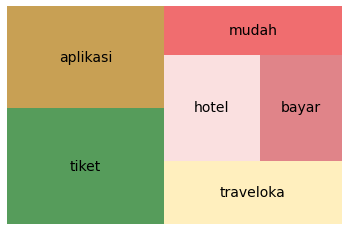

In [ ]:
import squarify

most_common_word = dict(counted_words.most_common(6))
volume = most_common_word.values()
labels = most_common_word.keys()
color_list = ['#0f7216', '#b2790c', '#ffe9a3',
              '#f9d4d4', '#d35158', '#ea3033']

plt.rc('font', size=14)
squarify.plot(sizes=volume, label=labels,
              color=color_list, alpha=0.7)
plt.axis('off')

plt.show()

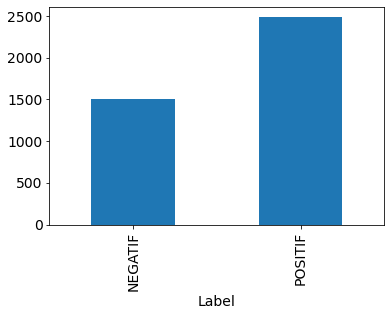

In [ ]:
df['Tokenize'].groupby(df['Label']).count().plot(kind='bar')
plt.show()

In [ ]:
Positive_sent = df[df['Label']=='POSITIF']
Negative_sent = df[df['Label']=='NEGATIF']

In [ ]:
#MosT common positive words
top = Counter([item for sublist in Positive_sent['Tokenize'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(5))
temp_positive.columns = ['Common_words','count']
temp_positive.style.background_gradient(cmap='Greens')

,Common_words,count
0,mudah,456
1,bantu,420
2,tiket,376
3,aplikasi,334
4,murah,267


In [ ]:
#MosT common negative words
top = Counter([item for sublist in Negative_sent['Tokenize'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(5))
temp_positive.columns = ['Common_words','count']
temp_positive.style.background_gradient(cmap='Greens')

,Common_words,count
0,tiket,652
1,aplikasi,569
2,traveloka,466
3,hotel,423
4,bayar,396


[Read Tutorial Worldcloud](https://www.geeksforgeeks.org/generating-word-cloud-python/)

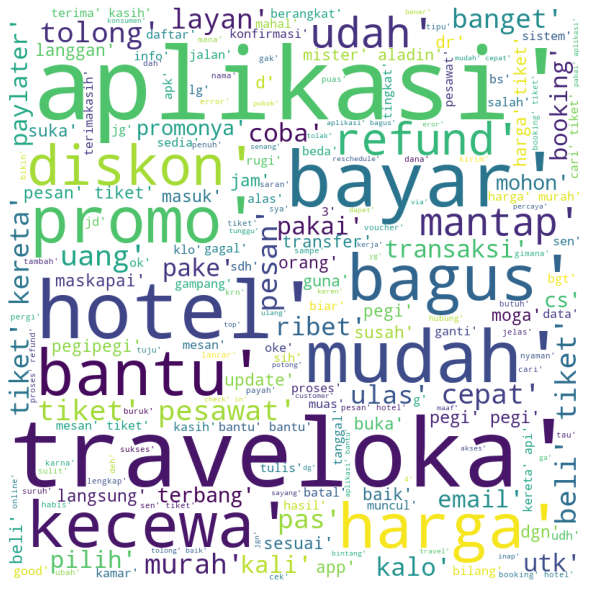

In [ ]:
# Python program to generate WordCloud 

# importing all necessery modules 
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 

comment_words = '' 
worcloud_stopwords = set(STOPWORDS) 

# iterate through the csv file 
for val in df.Tokenize: 
	
	# typecaste each val to string 
	val = str(val) 

	# split the value 
	tokens = val.split() 
	
	# Converts each token into lowercase 
	for i in range(len(tokens)): 
		tokens[i] = tokens[i].lower() 
	
	comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800, 
				background_color ='white', 
				stopwords = worcloud_stopwords, 
				min_font_size = 10).generate(comment_words) 

# plot the WordCloud image					 
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show() 


In [ ]:
def get_word(df):
  comment_words = '' 
  stopwords = set(STOPWORDS) 
    
  # iterate through the csv file 
  for val in df: 
      # typecaste each val to string 
      val = str(val) 
    
      # split the value 
      tokens = val.split() 
        
      # Converts each token into lowercase 
      for i in range(len(tokens)): 
          tokens[i] = tokens[i].lower() 
        
      comment_words += " ".join(tokens)+" "
  
  return comment_words

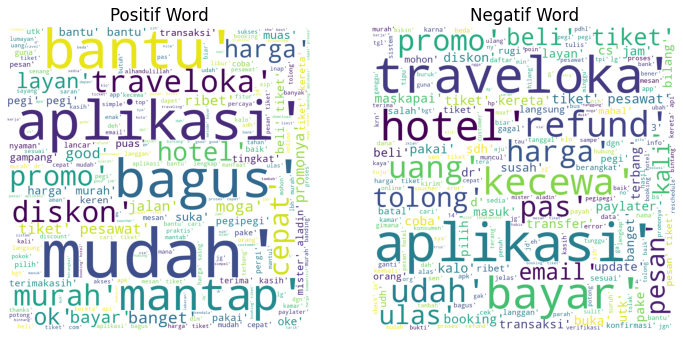

In [ ]:
positif_word = get_word(Positive_sent['Tokenize'])
negatif_word = get_word(Negative_sent['Tokenize'])
  
wordcloud_positif = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(positif_word) 

  
wordcloud_negatif = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(negatif_word) 
  

  
# plot the WordCloud image                        
plt.figure(figsize = (12, 12), facecolor = None) 
plt.tight_layout(pad = 0) 

plt.subplot(1,2,1)
plt.imshow(wordcloud_positif)
plt.axis("off") 
plt.title("Positif Word")

plt.subplot(1,2,2)
plt.imshow(wordcloud_negatif)
plt.title("Negatif Word")
plt.axis("off") 

  
plt.show() 

## Prepare Training data 

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, roc_auc_score, recall_score, precision_score
from nltk.stem import SnowballStemmer

In [ ]:
df.head()

,Name,Review,Label,Hasil_preprocessing,Tokenize
0,Yuki Audhia,Kesekian kalinya beli tiket kereta api disini ...,POSITIF,sekian kali beli tiket kereta api n tdk kecewa...,"[sekian, kali, beli, tiket, kereta, api, tdk, ..."
1,Novita Vita,"Mantul lah...mudah""an lbih baik lagi.. Cepa...",POSITIF,mantul mudah an lbih cepat g neko saran mudah ...,"[mantul, mudah, an, lbih, cepat, g, neko, sara..."
2,Mulasih Tary,"Baru mau pakai aplikasi ini, saya akan beri ul...",POSITIF,pakai aplikasi ulas stelah maka bintang 5 sesuai,"[pakai, aplikasi, ulas, stelah, maka, bintang,..."
3,Heri Waluyo,Mohon maaf sebelumnya cuma mau kasih saran aja...,NEGATIF,mohon maaf kasih saran aja klo maju sukses apl...,"[mohon, maaf, kasih, saran, klo, maju, sukses,..."
4,el Junior toys,Sejak di iklanin di tv. Diskon keretanya udah ...,NEGATIF,iklanin tv diskon kereta udah ga lg pindah bel...,"[iklanin, tv, diskon, kereta, udah, lg, pindah..."


In [ ]:
df = df.replace('POSITIF', 1)
df = df.replace('NEGATIF', 0)
df.head()

,Name,Review,Label,Hasil_preprocessing,Tokenize
0,Yuki Audhia,Kesekian kalinya beli tiket kereta api disini ...,1,sekian kali beli tiket kereta api n tdk kecewa...,"[sekian, kali, beli, tiket, kereta, api, tdk, ..."
1,Novita Vita,"Mantul lah...mudah""an lbih baik lagi.. Cepa...",1,mantul mudah an lbih cepat g neko saran mudah ...,"[mantul, mudah, an, lbih, cepat, g, neko, sara..."
2,Mulasih Tary,"Baru mau pakai aplikasi ini, saya akan beri ul...",1,pakai aplikasi ulas stelah maka bintang 5 sesuai,"[pakai, aplikasi, ulas, stelah, maka, bintang,..."
3,Heri Waluyo,Mohon maaf sebelumnya cuma mau kasih saran aja...,0,mohon maaf kasih saran aja klo maju sukses apl...,"[mohon, maaf, kasih, saran, klo, maju, sukses,..."
4,el Junior toys,Sejak di iklanin di tv. Diskon keretanya udah ...,0,iklanin tv diskon kereta udah ga lg pindah bel...,"[iklanin, tv, diskon, kereta, udah, lg, pindah..."


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3991 entries, 0 to 3995
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Name                 3991 non-null   object
 1   Review               3991 non-null   object
 2   Label                3991 non-null   int64 
 3   Hasil_preprocessing  3991 non-null   object
 4   Tokenize             3991 non-null   object
dtypes: int64(1), object(4)
memory usage: 347.1+ KB


In [ ]:
train, test = train_test_split(df, test_size=0.3, random_state=1)
X_train = train['Tokenize'].apply(lambda x :  ' '.join(x)).values
X_test = test['Tokenize'].apply(lambda x :  ' '.join(x)).values
y_train = train['Label'].values
y_test = test['Label'].values

In [ ]:
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

2793
2793
1198
1198


## Model

In [ ]:
kfolds = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
vectorizer1 = TfidfVectorizer()

result_training  = []

In [ ]:
%cd /content/drive/My Drive/Project/Data Science/PeduliLindungi Sentimen Analisis/model


/content/drive/My Drive/Project/Data Science/PeduliLindungi Sentimen Analisis/model


### Machine Learning Model

proses pelatihan model machine learning menggunakan 2 cara yaitu
menggunakan pipeline dan tidak

### Pipeline
Keuntungan menggunakan pipeline, khususnya dalam NLP adalah saat memprediksi tidak perlu mengubah masukan menjadi bentuk angka
[Read Tutorial](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)

#### SVM 

In [ ]:
param_grid = {'svc__C': [0.1, 1, 10, 100, 1000],  
              'svc__gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'svc__kernel': ['rbf']}  
  
# grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3) 
pipeline_svm = make_pipeline(vectorizer1, 
                            SVC())

svm = GridSearchCV(pipeline_svm,
                    param_grid,
                    cv = kfolds,
                    scoring="roc_auc",
                    verbose=1,   
                    n_jobs=-1) 
  
# fitting the model for grid search 
svm.fit(X_train, y_train) 

Fitting 10 folds for each of 25 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  1.9min finished


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=1, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('tfidfvectorizer',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                     

In [ ]:
print(svm.best_params_)
print(svm.best_score_)

{'svc__C': 1, 'svc__gamma': 1, 'svc__kernel': 'rbf'}
0.9544216232066656


In [ ]:
result_training.append(['SVC',svm.best_score_])

In [ ]:

joblib.dump(svm, 'svm.pickle')


/content/drive/My Drive/Project/Data Science/PeduliLindungi Sentimen Analisis/model


['svm.pickle']

#### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier


param_knn = {'kneighborsclassifier__n_neighbors': np.arange(50),
             'kneighborsclassifier__weights' : ['uniform', 'distance'],
             'kneighborsclassifier__metric' : ['euclidean', 'manhattan', 'minkowski']    
             }  
 
  
# grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3) 
pipeline_knn = make_pipeline(vectorizer1, 
                            KNeighborsClassifier())

knn = GridSearchCV(pipeline_knn,
                    param_knn,
                    cv = kfolds,
                    scoring="roc_auc",
                    verbose=1,   
                    n_jobs=-1) 

knn.fit(X_train, y_train)
knn.score(X_test, y_test)

Fitting 10 folds for each of 300 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 370 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 870 tasks      | elapsed:   40.3s
[Parallel(n_jobs=-1)]: Done 1570 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 2470 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  3.0min finished


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=1, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('tfidfvectorizer',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                     

In [ ]:
print(knn.best_params_)
print(knn.best_score_)

{'kneighborsclassifier__metric': 'euclidean', 'kneighborsclassifier__n_neighbors': 49, 'kneighborsclassifier__weights': 'distance'}
0.9213558866922786


In [ ]:
result_training.append(['KNeighborsClassifier',knn.best_params_])

In [ ]:
joblib.dump(knn, 'knn.pickle')


['knn.pickle']

In [ ]:
knn.predict(['product bagus'])

array([1])

#### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

pipeline_random_forest = make_pipeline(vectorizer1, 
                            RandomForestClassifier())
# Choose some parameter combinations to try
param_random_forest = {'randomforestclassifier__n_estimators': [4, 6, 9], 
              'randomforestclassifier__max_features': ['log2', 'sqrt','auto'], 
              'randomforestclassifier__criterion': ['entropy', 'gini'],
              'randomforestclassifier__max_depth': [2, 3, 5, 10], 
              'randomforestclassifier__min_samples_split': [2, 3, 5],
              'randomforestclassifier__min_samples_leaf': [1,5,8]
             }


random_forest = GridSearchCV(pipeline_random_forest,
                    param_random_forest, 
                    cv = kfolds,
                    scoring="roc_auc",
                    verbose=1,   
                    n_jobs=-1) 
  
# fitting the model for grid search 
random_forest.fit(X_train, y_train)
random_forest.score(X_test, y_test)

Fitting 10 folds for each of 648 candidates, totalling 6480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 368 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done 868 tasks      | elapsed:   39.5s
[Parallel(n_jobs=-1)]: Done 1568 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2468 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 3568 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 4868 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 6368 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 6480 out of 6480 | elapsed:  5.0min finished


0.8925642443902948

In [ ]:
print(random_forest.best_params_)
print(random_forest.best_score_)
joblib.dump(random_forest, 'random_forest.pickle')

{'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_depth': 10, 'randomforestclassifier__max_features': 'auto', 'randomforestclassifier__min_samples_leaf': 5, 'randomforestclassifier__min_samples_split': 5, 'randomforestclassifier__n_estimators': 9}
0.8840962842937049


['random_forest.pickle']

In [ ]:
acc = random_forest.score(X_test, y_test)
result_training.append(['RandomForestClassifier',acc])

In [ ]:
random_forest.predict(['product bagus'])

array([1])

### Without Pipeline

#### Naive Bayes

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv = CountVectorizer(ngram_range = (1,1),tokenizer = token.tokenize)
text_counts = cv.fit_transform(df['Tokenize'].apply(lambda x :  ' '.join(x)))

kita perlu menyimpan vocab ini, agar bisa saat proses prediksi konfigurasi CountVectorizer bisa sama saat pelatihan

In [ ]:
vocab = df['Tokenize'].apply(lambda x :  ' '.join(x))
joblib.dump(vocab, 'vocabulary.txt')

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(text_counts, df['Label'], test_size=0.25, random_state=5)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2993, 4850)
(2793,)
(998, 4850)
(1198,)


In [ ]:
from sklearn.naive_bayes import MultinomialNB, ComplementNB, GaussianNB, BernoulliNB
from sklearn.metrics import accuracy_score

##### MultinomialNB

In [ ]:
MNB = MultinomialNB()
MNB.fit(X_train, Y_train)
accuracyscore = accuracy_score(MNB.predict(X_test),Y_test)

result_training.append(['MultinomialNB',accuracyscore])
print('MultinomialNB accuracy = ' + str('{:4.2f}'.format(accuracyscore*100))+'%')

MultinomialNB accuracy = 90.78%


In [ ]:
joblib.dump(MNB, 'MNB.pickle')


['MNB.pickle']

In [ ]:
word_test = cv.transform(['product ini bagus','jelek'])
word_test.shape
MNB.predict(word_test)

array([1, 0])

##### ComplementNB

In [ ]:
CNB = ComplementNB()
CNB.fit(X_train, Y_train)
accuracyscore = accuracy_score(CNB.predict(X_test),Y_test)

result_training.append(['ComplementNB',accuracyscore])

print('ComplementNB accuracy = ' + str('{:4.2f}'.format(accuracyscore*100))+'%')

ComplementNB accuracy = 88.78%


In [ ]:
joblib.dump(CNB, 'CNB.pickle')


['CNB.pickle']

##### BernoulliNB

In [ ]:
BNB = BernoulliNB()
BNB.fit(X_train, Y_train)
accuracyscore = accuracy_score(BNB.predict(X_test),Y_test)

result_training.append(['BernoulliNB',accuracyscore])

print('BernoulliNB accuracy = ' + str('{:4.2f}'.format(accuracyscore*100))+'%')


BernoulliNB accuracy = 82.26%


In [ ]:
joblib.dump(BNB, 'BNB.pickle')


['BNB.pickle']

#### Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

decision_tree = DecisionTreeClassifier()

decision_tree.fit(X_train, Y_train)

accuracyscore = accuracy_score(decision_tree.predict(X_test),Y_test)

result_training.append(['DecisionTreeClassifier',accuracyscore])

print('DecisionTreeClassifier accuracy = ' + str('{:4.2f}'.format(accuracyscore*100))+'%')

DecisionTreeClassifier accuracy = 83.47%


In [ ]:
joblib.dump(decision_tree, 'DecisionTreeClassifier.pickle')


['DecisionTreeClassifier.pickle']

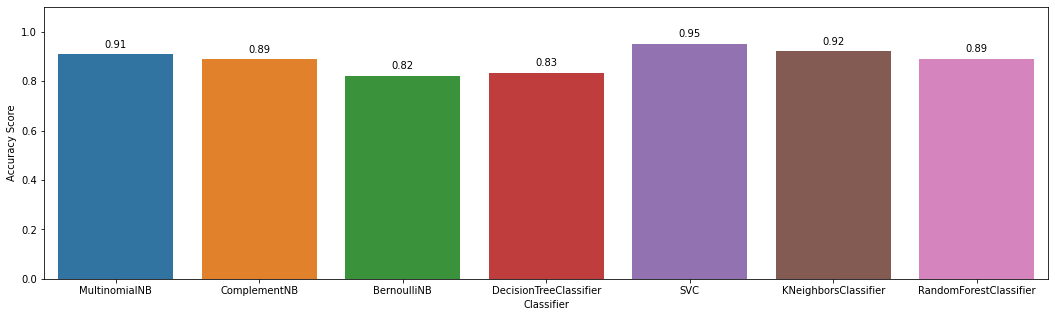

In [ ]:
plt.figure(figsize = (18,5))
plt.ylim(0, 1.1)
g = sns.barplot(x = 'Classifier', y = 'Accuracy Score', data = df_training)
for p in g.patches:
  g.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

plt.show()

### Deep Learning Model

[Read this tutorial](https://www.kaggle.com/anjanatiha/sentiment-analysis-with-lstm-cnn)

##### Import library

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, GlobalMaxPooling1D, Conv1D, BatchNormalization, Dense, Dropout, Flatten
from keras.optimizers import Adam
from keras.utils import to_categorical

from sklearn.utils import class_weight as cw

Using TensorFlow backend.


##### Split data train and test

In [ ]:
X = df['Tokenize'].apply(lambda x :  ' '.join(x))
Y = to_categorical(df['Label'].values)
X_train, X_test, Y_train, Y_test = train_test_split(X,Y , test_size=0.15)

max_words = len(set(" ".join(X_train).split()))
max_len = X_train.apply(lambda x: len(x)).max()

In [ ]:
%cd /content/drive/My Drive/Project/Data Science/PeduliLindungi Sentimen Analisis/train_test data
np.save("X_train.npy", X_train)
np.save("X_test.npy", X_test)
np.save("Y_train.npy", Y_train)
np.save("Y_test.npy", Y_test)


/content/drive/My Drive/Project/Data Science/PeduliLindungi Sentimen Analisis/train_test data


max_words and max_len perlu disimpan, untuk penyesuaian konfigutasi prediksi

In [ ]:
print(max_words)# banyaknya kata pada data latih
# max length wotd
print(max_len) # kalimat terpanjang dari data latih

4391
619


##### Tokenizer data and change to sequences

In [ ]:
tokenizer = Tokenizer(num_words=max_words)

tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_train_seq = pad_sequences(X_train_seq, maxlen=max_len)

##### get weight of each class

In [ ]:
def get_weight(y):
    class_weight_current =  cw.compute_class_weight('balanced', np.unique(y), y)
    return class_weight_current

class_weight = get_weight(Y_train.flatten())

##### Callbacks Settings

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau
model_dir= '/content/drive/My Drive/Project/Data Science/PeduliLindungi Sentimen Analisis/model/'  
model_file_CNN = f"{model_dir}/CNN/CNN" + "{epoch:02d}-val_acc-{val_accuracy:.2f}-val_loss-{val_loss:.2f}.hdf5"
model_file_LSTM = f"{model_dir}/LSTM/LSTM" + "{epoch:02d}-val_acc-{val_accuracy:.2f}-val_loss-{val_loss:.2f}.hdf5"


checkpoint = ModelCheckpoint(
    model_file_CNN, 
    monitor='val_accuracy', 
    save_best_only=True)

checkpoint_LSTM = ModelCheckpoint(
    model_file_LSTM, 
    monitor='val_accuracy', 
    save_best_only=True)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    verbose=1,
    restore_best_weights=True)


reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=1,
    verbose=1)


callbacks = [checkpoint, reduce_lr, early_stopping]
callbacks_LSTM = [checkpoint_LSTM, reduce_lr, early_stopping]




#### CNN Model

##### Create a model

In [ ]:
def get_cnn_model(num_class=2):   
    model = Sequential()
    
    model.add(Embedding(max_words, 100, input_length=max_len))
    
    model.add(Conv1D(1024, 3, padding='valid', activation='relu', strides=1))
    model.add(GlobalMaxPooling1D())
    
    
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(2048, activation='relu'))
    
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    if num_class>2:
        model.add(Dense(num_class, activation='softmax'))
    else:
        model.add(Dense(2, activation='softmax'))
    
    model.summary()
    return model

In [ ]:
cnn_model = get_cnn_model()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 619, 100)          439100    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 617, 1024)         308224    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4096      
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2048)             

##### Train model

In [ ]:
verbose = 1
epochs = 50
batch_size = 128
validation_split = 0.2

cnn_model.compile(optimizer=Adam(lr= 0.1), loss= 'categorical_crossentropy', metrics= ['accuracy'])
history = cnn_model.fit(X_train_seq, 
                        Y_train, 
                        batch_size=batch_size,
                        epochs=epochs, 
                        verbose=verbose, callbacks=callbacks, 
                        validation_split= 0.2,
                        class_weight =class_weight
                        )

Train on 2713 samples, validate on 679 samples
Epoch 1/50
2713/2713 [==============================] - 10s 4ms/step - loss: 12.4806 - accuracy: 0.7173 - val_loss: 249.5784 - val_accuracy: 0.3476
Epoch 2/50
2713/2713 [==============================] - 4s 1ms/step - loss: 3.9215 - accuracy: 0.8555 - val_loss: 48.5607 - val_accuracy: 0.5096
Epoch 3/50
2713/2713 [==============================] - 4s 1ms/step - loss: 2.4425 - accuracy: 0.8887 - val_loss: 17.4378 - val_accuracy: 0.7629
Epoch 4/50
2713/2713 [==============================] - 4s 1ms/step - loss: 1.4030 - accuracy: 0.9031 - val_loss: 14.9927 - val_accuracy: 0.7585
Epoch 5/50
2713/2713 [==============================] - 4s 1ms/step - loss: 1.3247 - accuracy: 0.9211 - val_loss: 12.7886 - val_accuracy: 0.7143
Epoch 6/50
2713/2713 [==============================] - 4s 1ms/step - loss: 1.1073 - accuracy: 0.9233 - val_loss: 6.7069 - val_accuracy: 0.8660
Epoch 7/50
2713/2713 [==============================] - 4s 1ms/step - loss: 0.880

In [ ]:
coba = ['product ini bagus']
coba = tokenizer.texts_to_sequences(coba)
coba = pad_sequences(coba, maxlen=max_len)

a = cnn_model.predict(coba)
print(a)
np.argmax(a)

[[1.9963625e-06 9.9999797e-01]]


1

In [ ]:
coba = ['product ini jelek']
coba = tokenizer.texts_to_sequences(coba)
coba = pad_sequences(coba, maxlen=max_len)

a = cnn_model.predict(coba)
print(a)
np.argmax(a)

[[9.9984968e-01 1.5028082e-04]]


0

In [ ]:
test_X_seq = tokenizer.texts_to_sequences(X_test)
test_X_seq = pad_sequences(test_X_seq, maxlen=max_len)

In [ ]:
accuracy = cnn_model.evaluate(test_X_seq, Y_test)
result_training.append(['CNN', accuracy[1]])
accuracy

599/599 [==============================] - 0s 722us/step


[1.3214132544990373, 0.8831385374069214]

##### SaveModel


In [ ]:
cnn_model.save('CNN_model.h5')

In [ ]:
cnn_model.save_weights('CNN_model_weight.h5')

#### LSTM Model

In [ ]:
from keras.layers import LSTM

In [ ]:
def get_lstm_model(num_class=2):
    model = Sequential()
    
    model.add(Embedding(max_words, 100, input_length=max_len))
    model.add(LSTM(256))
    
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(512, activation='relu'))
    
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(num_class, activation='softmax'))
    model.summary()
    
    return model

##### Create Model

In [ ]:
lstm_model = get_lstm_model()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 619, 100)          439100    
_________________________________________________________________
lstm_3 (LSTM)                (None, 256)               365568    
_________________________________________________________________
dropout_13 (Dropout)         (None, 256)               0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_14 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               131584    
_________________________________________________________________
dropout_15 (Dropout)         (None, 512)              

##### Train Model

In [ ]:
lstm_model.compile(optimizer=Adam(lr= 0.1), loss= 'categorical_crossentropy', metrics= ['accuracy'])
history_lstm = lstm_model.fit(X_train_seq, 
                        Y_train, 
                        batch_size=batch_size,
                        epochs=epochs, 
                        verbose=verbose, callbacks=callbacks_LSTM, 
                        validation_split= 0.2,
                        class_weight =class_weight
                        )

In [ ]:
accuracy = lstm_model.evaluate(test_X_seq, Y_test)
result_training.append(['LSTM', accuracy[1]])
accuracy

##### Save Model

In [ ]:
lstm_model.save('LSTM_Sentimen.h5')

## Result Training

In [ ]:
df_training = pd.DataFrame(result_training, columns=['Classifier', 'Accuracy Score'])
df_training

,Classifier,Accuracy Score
0,MultinomialNB,0.907816
1,ComplementNB,0.887776
2,BernoulliNB,0.822645
3,DecisionTreeClassifier,0.834669
4,SVC,0.950000
5,KNeighborsClassifier,0.920000
6,RandomForestClassifier,0.890000
7,CNN,0.861436
8,LSTM,0.813022


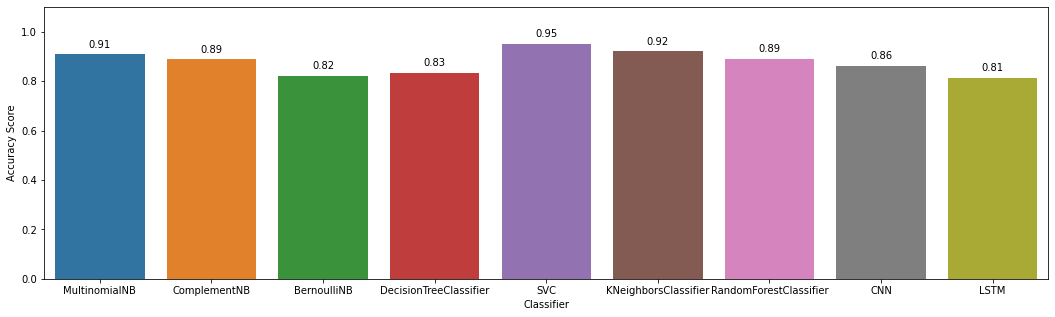

In [ ]:
plt.figure(figsize = (18,5))
plt.ylim(0, 1.1)
g = sns.barplot(x = 'Classifier', y = 'Accuracy Score', data = df_training)
for p in g.patches:
  g.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

plt.show()

In [ ]:
df_training.to_csv('Hasil Training.csv')

In [ ]:
result = df_training.sort_values(by=['Accuracy Score'], ascending=False)
result

,Classifier,Accuracy Score
4,SVC,0.950000
5,KNeighborsClassifier,0.920000
0,MultinomialNB,0.907816
6,RandomForestClassifier,0.890000
1,ComplementNB,0.887776
7,CNN,0.861436
3,DecisionTreeClassifier,0.834669
2,BernoulliNB,0.822645
8,LSTM,0.813022


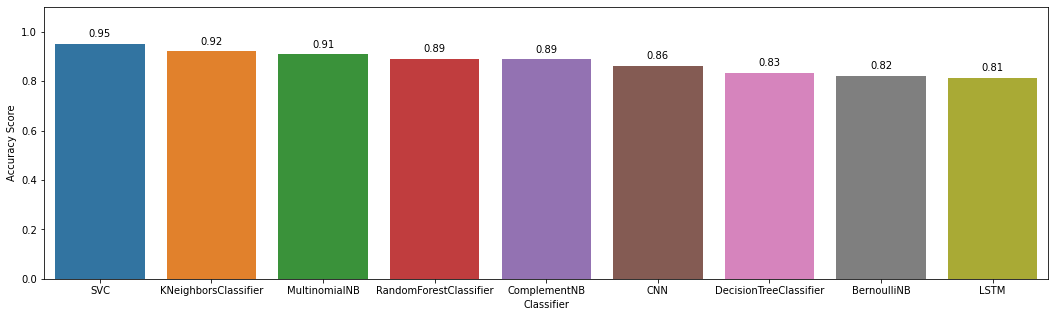

In [ ]:
plt.figure(figsize = (18,5))
plt.ylim(0, 1.1)
g = sns.barplot(x = 'Classifier', y = 'Accuracy Score', data = result, order=  result['Classifier'])
for p in g.patches:
  g.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

plt.show()